In [3]:
main_dir = '/Users/simon/bsose_monthly/'
salt = main_dir + 'bsose_i106_2008to2012_monthly_Salt.nc'
theta = main_dir + 'bsose_i106_2008to2012_monthly_Theta.nc'

%load_ext autoreload
%autoreload 2
import numpy as np
import xarray as xr
xr.set_options(keep_attrs=True)
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature
import matplotlib.path as mpath
import os, sys
sys.path.insert(0, os.path.abspath('..'))

import pyxpcm
from pyxpcm.models import pcm


def pcm_fit_and_post(time_i=42, K=4, maxvar=2):  
    # Define features to use
    # Instantiate the PCM
    
    max_depth = 2000
    z = np.arange(0., -max_depth, -10.)
    features_pcm = {'THETA': z, 'SALT': z}
    features = {'THETA': 'THETA', 'SALT': 'SALT'}
    salt_nc = xr.open_dataset(salt).isel(time=time_i)
    theta_nc = xr.open_dataset(theta).isel(time=time_i)
    big_nc = xr.merge([salt_nc, theta_nc])
    both_nc = big_nc.where(big_nc.coords['Depth'] > 
                           max_depth).drop(['iter', 'Depth', 
                                            'rA', 'drF', 'hFacC'])   
 
    attr_d = {}

    for coord in both_nc.coords:
        attr_d[coord] = both_nc.coords[coord].attrs
        
    lons_new = np.linspace(both_nc.XC.min(), both_nc.XC.max(), 60*4)
    lats_new = np.linspace(both_nc.YC.min(), both_nc.YC.max(), 60)
    # ds = both_nc # .copy(deep=True)
    ds = both_nc.interp(coords={'YC': lats_new, 'XC': lons_new})#, method='cubic')
        
    m = pcm(K=K, features=features_pcm, 
            maxvar=maxvar, 
            #timeit=True, timeit_verb=1, 
            separate_pca=False)
    m.fit(ds, features=features, dim='Z') #, inplace=True)
    m.predict(ds, features=features, dim='Z', inplace=True)
    m.predict_proba(ds, features=features, dim='Z', inplace=True)
    m.find_i_metric(ds, inplace=True)
    
    def sanitize():
        del ds.PCM_LABELS.attrs['_pyXpcm_cleanable']
        del ds.PCM_POST.attrs['_pyXpcm_cleanable']
        del ds.PCM_RANK.attrs['_pyXpcm_cleanable']
        
    for coord in attr_d:
        ds.coords[coord].attrs = attr_d[coord]
    
    sanitize()
    return ds, m

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
ds, m = pcm_fit_and_post(time_i=42, K=4, maxvar=2)

Fitting PCA
[(0, 0), (1, 0), (1, 1), (2, 0), (2, 1), (2, 2), (3, 0), (3, 1), (3, 2), (3, 3)]
(10437, 2)
(10437, 4)


In [31]:
shape = np.shape(ds.PCM_POST.values)
ic_metric = np.zeros([shape[1], shape[2]])
a_b = np.zeros([2, shape[1], shape[2]])

for i in range(shape[1]):
    for j in range(shape[2]):
        ic_metric[i, j], a_b[:, i, j] = get_i_metric(ds.PCM_POST.values[:, i, j].tolist())

In [26]:
def get_i_metric(posterior_prob_list):
    """
    :return: gmm_profile list:
    :return: gmm: the gmm object to save.
    """
    if np.nan not in posterior_prob_list:

        sorted_posterior_list = sorted(posterior_prob_list)

        ic_metric = 1 - (sorted_posterior_list[-1] - sorted_posterior_list[-2])

        runner_up_label = posterior_prob_list.index(sorted_posterior_list[-2])

        label = posterior_prob_list.index(sorted_posterior_list[-1])

        return ic_metric, np.array([label, runner_up_label])
    
    else:
        
        return np.nan, np.array([np.nan, np.nan])


In [29]:
shape

(4, 60, 240)

In [32]:
ic_metric

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0., nan, ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [33]:
np.shape(ic_metric)

(60, 240)

In [34]:
a_b

array([[[3., 3., 3., ..., 3., 3., 3.],
        [3., 3., 3., ..., 3., 3., 3.],
        [3., 3., 3., ..., 3., 3., 3.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 3., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[2., 2., 2., ..., 2., 2., 2.],
        [2., 2., 2., ..., 2., 2., 2.],
        [2., 2., 2., ..., 2., 2., 2.],
        ...,
        [2., 2., 2., ..., 2., 2., 2.],
        [2., 2., 2., ..., 2., 2., 2.],
        [2., 2., 2., ..., 2., 2., 2.]]])

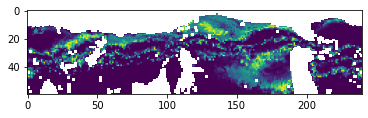

In [36]:
plt.imshow(ic_metric)
plt.colorbar()